## **Introduction**

#### This study focused on developing a machine learning model to classify electrocardiogram (ECG) signals into normal and abnormal rhythms, specifically targeting arrhythmia detection. Initial attempts using raw ECG signals with Recurrent Neural Networks (RNN) and Long Short-Term Memory (LSTM) networks resulted in suboptimal performance. To enhance the model's accuracy, we implemented a feature extraction process to derive informative time-frequency features from the ECG signals before training the LSTM model.

### **Dataset Overview**

Your dataset `ECGData.mat` contains:

- **Signals**: A 162x65536 matrix where each row represents an ECG signal of length 65,536 samples.
- **Labels**: A 162x1 cell array containing labels for each signal.
- **Labels Meaning**:
    - `'ARR'`: Arrhythmia (from MIT-BIH Arrhythmia Database)
    - `'CHF'`: Congestive Heart Failure (from BIDMC Congestive Heart Failure Database)
    - `'NSR'`: Normal Sinus Rhythm (from MIT-BIH Normal Sinus Rhythm Database)
- **Sampling Rate**: All signals have been resampled to **128 Hz**.
- **Signal Length**: Each signal is **65536 samples long**, corresponding to approximately 8.5 minutes of data (since 65536 samples / 128 Hz ≈ 512 seconds).

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam  # Keras 3
from tensorflow.keras.callbacks import EarlyStopping


In [10]:
################################################################################
# 1) LOAD AND PREPARE DATA
# In this section, we load ECG data, preprocess it, and prepare it for machine learning.
################################################################################

# Set random seed for reproducibility
random_state = 42

# Load the data from a MATLAB file
# The dataset contains ECG signals and their corresponding labels.
data = loadmat('ECGData.mat')
ecg_data = data['ECGData']
ecg_data_item = ecg_data[0, 0]

# Extract signals and labels from the dataset
Signals = ecg_data_item['Data']        # Shape: (N, 65536)
Labels_array = ecg_data_item['Labels'] # Shape: (N, 1)

# Convert labels to a human-readable format
Labels = [Labels_array[i, 0][0] for i in range(Labels_array.shape[0])]

# Map the labels to binary categories: 'N' for normal and 'A' for abnormal
Labels_mapped = ['N' if lb == 'NSR' else 'A' if lb in ['ARR', 'CHF'] else 'Other' for lb in Labels]
Labels_mapped = np.array(Labels_mapped)

# Encode the labels to integers: 1 for 'N', 0 for 'A'
le = LabelEncoder()
encoded_labels = le.fit_transform(Labels_mapped)

# Standardize each ECG signal (zero mean and unit variance)
all_signals = []
for sig in Signals:
    sig = sig.astype(np.float32)
    m, s = np.mean(sig), np.std(sig)
    s = max(s, 1e-6)  # Avoid division by zero
    all_signals.append((sig - m) / s)
all_signals = np.array(all_signals)

# Print shapes to understand the data structure
print("Original signals shape:", all_signals.shape)
print("Labels shape:", encoded_labels.shape)

# Ensure all binary samples are fed into the model
print("Number of Normal Samples: ", len(Labels_mapped[Labels_mapped == 'N']))
print("Number of Abnormal Samples: ", len(Labels_mapped[Labels_mapped == 'A']))
print("Number of Other Samples: ", len(Labels_mapped[Labels_mapped == 'Other']))

print('\nEncoded Labels: ', encoded_labels)
print('Normal Encoded Labels: ', len(encoded_labels[encoded_labels == 0]))
print('Abnormal Encoded Labels: ', len(encoded_labels[encoded_labels == 1]))



Original signals shape: (162, 65536)
Labels shape: (162,)
Number of Normal Samples:  36
Number of Abnormal Samples:  126
Number of Other Samples:  0

Encoded Labels:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Normal Encoded Labels:  126
Abnormal Encoded Labels:  36


In [11]:
################################################################################
# 2) SEGMENT SIGNALS INTO WINDOWS
# Here, we divide long ECG signals into smaller segments for model training.
################################################################################

def segment_signals(signals, labels, sample_time_size=10, step_size=None):
    """
    Segment each long ECG signal into smaller windows of length 128 * sample_time_size.
    - Window size is determined by the sample rate (128 Hz) and sample time.
    - Step size controls the overlap between windows.
    """
    window_size = 128 * sample_time_size
    step_size = step_size or window_size

    segs, seg_labels = [], []
    for i in range(len(signals)):
        sig = signals[i]
        lbl = labels[i]
        for start in range(0, len(sig) - window_size + 1, step_size):
            segs.append(sig[start : start + window_size])
            seg_labels.append(lbl)
    return np.array(segs), np.array(seg_labels)

# Segment the signals and print the resulting shapes
X_segments, Y_segments = segment_signals(all_signals, encoded_labels, sample_time_size=5)
print("Segmented signals shape:", X_segments.shape)
print("Segmented labels shape:", Y_segments.shape)
print("Label distribution:", np.bincount(Y_segments))

Segmented signals shape: (16524, 640)
Segmented labels shape: (16524,)
Label distribution: [12852  3672]


In [12]:
################################################################################
# 3) NOISE FUNCTIONS
# This section introduces noise to the data to simulate real-world conditions.
################################################################################

def add_gaussian_noise(signal, noise_level=0.1):
    """Add Gaussian noise to a signal."""
    noise = np.random.normal(0.0, noise_level, size=signal.shape)
    return signal + noise

def add_uniform_noise(signal, noise_level=0.1):
    """Add uniform noise to a signal."""
    noise = np.random.uniform(-noise_level, noise_level, size=signal.shape)
    return signal + noise

def add_exponential_noise(signal, noise_level=0.1):
    """Add exponential noise to a signal."""
    noise = np.random.exponential(scale=noise_level, size=signal.shape)
    return signal + noise

In [16]:
################################################################################
# 4) BUILD LSTM MODEL
# Here, we define the LSTM architecture for binary classification.
################################################################################

def build_lstm(input_shape, units=32, learning_rate=1e-3):
    """
    Build an LSTM model with the specified input shape and hyperparameters.
    """
    model = Sequential()
    model.add(LSTM(units, input_shape=input_shape, activation='tanh'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Use the updated Adam optimizer with the correct parameter name
    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Define training parameters
EPOCHS = 5
BATCH_SIZE = 128
early_stop = EarlyStopping(patience=2, restore_best_weights=True)

In [17]:
################################################################################
# 5) TRAINING & EVALUATION
# This section includes functions to train and evaluate the LSTM model.
################################################################################

def train_evaluate_model(model, X_tr, y_tr, X_val, y_val, class_weight):
    """
    Train the model and evaluate its performance on validation data.
    """
    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        class_weight=class_weight,
        callbacks=[early_stop],
        verbose=1
    )
    val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
    y_val_probs = model.predict(X_val).ravel()
    val_auc = roc_auc_score(y_val, y_val_probs)
    return {
        'history': history.history,
        'val_acc': val_acc,
        'val_auc': val_auc
    }

def final_eval(model, X_test, y_test):
    """
    Evaluate the trained model on test data and calculate accuracy and AUC.
    """
    preds = model.predict(X_test).ravel()
    acc = accuracy_score(y_test, (preds > 0.5).astype(int))
    rocauc = roc_auc_score(y_test, preds)
    return acc, rocauc

In [18]:
################################################################################
# 6) MAIN LOOP OVER NOISE TYPES AND LEVELS
# Experiment with different types and levels of noise and observe the results.
################################################################################

# Define noise levels and types
noise_levels = [0.0, 0.1, 0.5]
noise_funcs = {
    'Gaussian': add_gaussian_noise,
    'Uniform': add_uniform_noise,
    'Exponential': add_exponential_noise
}

all_results = []

# Loop through noise types and levels
for noise_name, noise_func in noise_funcs.items():
    for nl in noise_levels:
        # Apply noise to each segment
        X_noisy = np.array([noise_func(seg, nl) for seg in X_segments])
        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_noisy, Y_segments, test_size=0.2, 
            random_state=random_state, stratify=Y_segments
        )
        
        # Reshape data for LSTM input
        X_train_3d = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test_3d = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        in_shape = (X_train_3d.shape[1], 1)

        # Further split training data into training and validation sets
        X_train_3d_, X_val_3d, y_train_, y_val = train_test_split(
            X_train_3d, y_train, test_size=0.2, 
            random_state=123, stratify=y_train
        )

        # Compute class weights
        class_weights = compute_class_weight(
            class_weight='balanced',
            classes=np.unique(y_train),
            y=y_train
        )
        class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

        # Build and train the LSTM model
        lstm_model = build_lstm(in_shape, units=64, learning_rate=1e-3)  # Updated argument
        lstm_info = train_evaluate_model(lstm_model, X_train_3d_, y_train_, X_val_3d, y_val, class_weight_dict)

        # Evaluate the model on test data
        lstm_test_acc, lstm_test_auc = final_eval(lstm_model, X_test_3d, y_test)

        # Store the results
        all_results.append({
            'NoiseType': noise_name,
            'NoiseLevel': nl,
            'Model': 'LSTM',
            'ValAccuracy': lstm_info['val_acc'],
            'ValAUC': lstm_info['val_auc'],
            'TestAccuracy': lstm_test_acc,
            'TestAUC': lstm_test_auc
        })


Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 246ms/step - accuracy: 0.6001 - loss: 0.6864 - val_accuracy: 0.6403 - val_loss: 0.6966
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 0.5007 - loss: 0.6800 - val_accuracy: 0.5151 - val_loss: 0.6540
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 0.5200 - loss: 0.6800 - val_accuracy: 0.4864 - val_loss: 0.6871
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 213ms/step - accuracy: 0.3876 - loss: 0.6868 - val_accuracy: 0.5507 - val_loss: 0.6869
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 238ms/step - accuracy: 0.5851 - loss: 0.6776 - val_accuracy: 0.7073 - val_loss: 0.6136
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 256ms/step - accuracy: 0.7115 - loss: 0.6249 - val_accuracy: 0.7878 - val_loss: 0.6265
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 21s 249ms/step - accuracy: 0.5730 - loss: 0.6744 - val_accuracy: 0.6218 - val_loss: 0.6549
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 232ms/step - accuracy: 0.5530 - loss: 0.6846 - val_accuracy: 0.7874 - val_loss: 0.5242
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.6795 - loss: 0.6330 - val_accuracy: 0.7057 - val_loss: 0.6065
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.6717 - loss: 0.6372 - val_accuracy: 0.6320 - val_loss: 0.6706
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.5803 - loss: 0.6936 - val_accuracy: 0.7825 - val_loss: 0.5665
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 236ms/step - accuracy: 0.7761 - loss: 0.6733 - val_accuracy: 0.7576 - val_loss: 0.6597
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.6411 - loss: 0.6835 - val_accuracy: 0.4709 - val_loss: 0.7032
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 215ms/step - accuracy: 0.5329 - loss: 0.6566 - val_accuracy: 0.3075 - val_loss: 0.7407
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.5671 - loss: 0.6863 - val_accuracy: 0.6433 - val_loss: 0.6365
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 206ms/step - accuracy: 0.6744 - loss: 0.6795 - val_accuracy: 0.7878 - val_loss: 0.6336
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 0.5623 - loss: 0.6910 - val_accuracy: 0.5639 - val_loss: 0.6679
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 208ms/step - accuracy: 0.6197 - loss: 0.6633 - val_accuracy: 0.4958 - val_loss: 0.7006
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 214ms/step - accuracy: 0.5035 - loss: 0.6846 - val_accuracy: 0.6812 - val_loss: 0.6488
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 217ms/step - accuracy: 0.4680 - loss: 0.7015 - val_accuracy: 0.4251 - val_loss: 0.6963
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Epoch 1/5


/Users/macbookpro2017/project research/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 18s 211ms/step - accuracy: 0.4575 - loss: 0.6842 - val_accuracy: 0.7050 - val_loss: 0.6706
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 17s 203ms/step - accuracy: 0.6751 - loss: 0.6702 - val_accuracy: 0.4629 - val_loss: 0.7203
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step



=== Results DataFrame ===
     NoiseType  NoiseLevel Model  ValAccuracy    ValAUC  TestAccuracy  \
0     Gaussian         0.0  LSTM     0.515129  0.658783      0.500756   
1     Gaussian         0.1  LSTM     0.707262  0.748782      0.698638   
2     Gaussian         0.5  LSTM     0.787443  0.759672      0.758548   
3      Uniform         0.0  LSTM     0.782526  0.598840      0.784569   
4      Uniform         0.1  LSTM     0.470877  0.657868      0.467776   
5      Uniform         0.5  LSTM     0.643343  0.626249      0.629955   
6  Exponential         0.0  LSTM     0.563918  0.665757      0.553101   
7  Exponential         0.1  LSTM     0.681165  0.573619      0.665658   
8  Exponential         0.5  LSTM     0.704992  0.591589      0.669894   

    TestAUC  
0  0.654135  
1  0.733415  
2  0.732967  
3  0.598898  
4  0.640878  
5  0.598230  
6  0.640371  
7  0.563668  
8  0.545448  


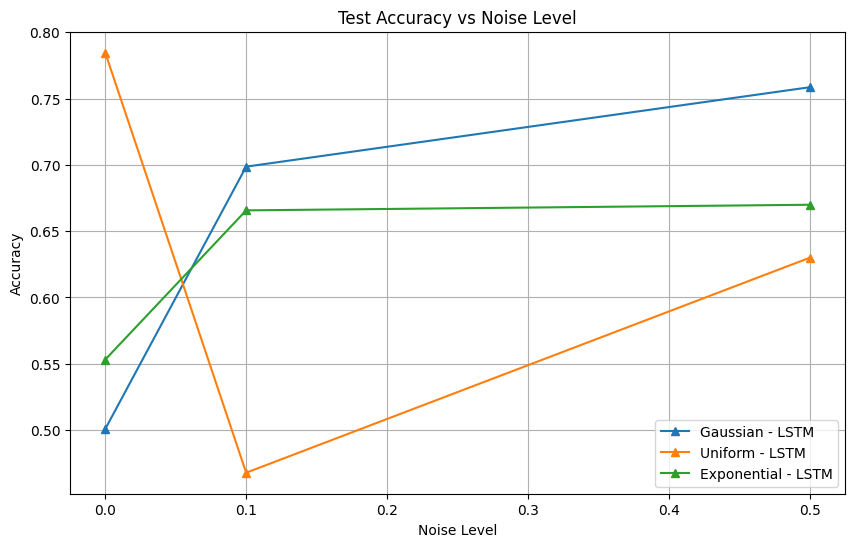

In [19]:
################################################################################
# 7) PLOT ACCURACY VS NOISE LEVEL
# Visualize how noise affects the model's performance.
################################################################################

df_results = pd.DataFrame(all_results)
print("\n=== Results DataFrame ===")
print(df_results)

plt.figure(figsize=(10,6))
for noise_name in noise_funcs.keys():
    sub_df = df_results[df_results['NoiseType'] == noise_name]
    lstm_vals = sub_df[sub_df['Model'] == 'LSTM'].sort_values('NoiseLevel')
    nl = sorted(sub_df['NoiseLevel'].unique())
    plt.plot(nl, lstm_vals['TestAccuracy'], marker='^', label=f'{noise_name} - LSTM')

plt.title('Test Accuracy vs Noise Level')
plt.xlabel('Noise Level')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Example final row:
 NoiseType       Exponential
NoiseLevel              0.5
Model                  LSTM
ValAccuracy        0.704992
ValAUC             0.591589
TestAccuracy       0.669894
TestAUC            0.545448
Name: 8, dtype: object
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step


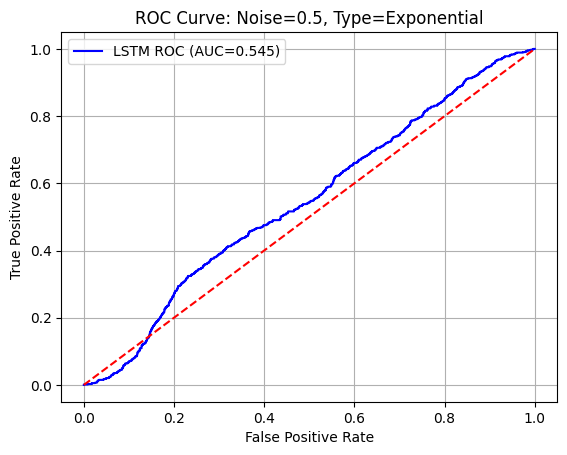

In [20]:
################################################################################
# 8) ROC CURVE EXAMPLE
# Examine the ROC curve for one example to understand model performance.
################################################################################

if len(df_results) > 0:
    last_row = df_results.iloc[-1]
    print("\nExample final row:\n", last_row)
    test_preds = lstm_model.predict(X_test_3d).ravel()
    fpr, tpr, _ = roc_curve(y_test, test_preds)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, label=f"LSTM ROC (AUC={roc_auc:.3f})", color='blue')
    plt.plot([0,1], [0,1], 'r--')
    plt.title(f"ROC Curve: Noise={last_row['NoiseLevel']}, Type={last_row['NoiseType']}")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.grid(True)
    plt.show()


Example final row:
 NoiseType       Exponential
NoiseLevel              0.5
Model                  LSTM
ValAccuracy        0.704992
ValAUC             0.591589
TestAccuracy       0.669894
TestAUC            0.545448
Name: 8, dtype: object
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step


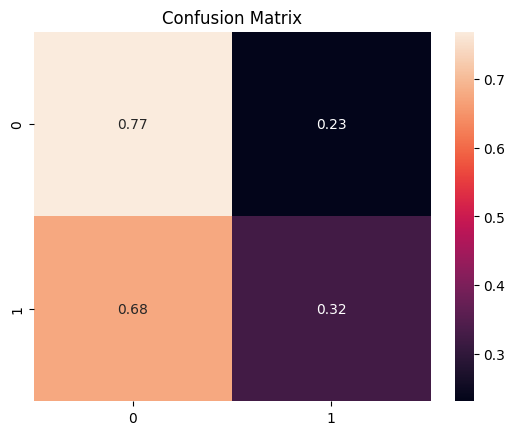

In [26]:
################################################################################
# 9) Confusion Matrix Example
# Examine the confusion to understand class balancing
################################################################################
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

if len(df_results) > 0:
    last_row = df_results.iloc[-1]
    print("\nExample final row:\n", last_row)
    test_preds = lstm_model.predict(X_test_3d).ravel()
    test_preds_classes = np.where(test_preds > 0.5, 1, 0)
    result = confusion_matrix(y_test, test_preds_classes, normalize='true')

    plt.figure()
    sn.heatmap(result, annot=True)
    plt.title('Confusion Matrix')
    plt.show()